# Watershed analysis with pysheds

In this case study we will cover how to extract watersheds and perform some example analyses of the elevation data in each watershed.

## Introduction

In this case study we will explore drainage basin hypsometry. To get started, we'll present a quick overview of some of the key background topics, as this could be a new topic for some readers. If you're already familiar with delineating watersheds and hypsometry, feel free to skip ahead to the next section.

### What is basin hypsometry?

A logical place to start is with defining basin hypsometry, why it is of interest, and what we need to be able to perform hypsometric analysis of a drainage basin. *{term}`Hypsometry <hypsometry>`* refers to the measurement of the distribution of elevations of Earth's (or other planet's) surface elevations within a given area. In essence, it is a means to explore how much land area is within different elevation ranges, similar to calculating a histogram of elevations. On Earth, for instance, we can observe that the majority of land area is at elevations within 800 meters of sea level, while little land area is at elevations greater than three kilometers. Drainage basin hypsometry refers to the measurement of the distribution of elevations within a river drainage basin (or watershed). Drainage basins are the land areas upstream of some point where a river flows out of its valley (the outlet). These regions are the hypothetical areas where any water flowing along Earth's surface would flow into the river being analyzed.

So, why do we care about drainage basin hypsometry? There are a few reasons basin hypsometry can be of interest, with one of them being the fact that the distribution of elevations in a drainage basin can tell us something about the geological processes that have shaped the land surface in the drainage basin. Rivers and glaciers carve their valleys into the underlying soil/rock in drainage basins, eroding the landscape and altering the distribution of elevations within the basin. In a classic article, Strahler (1952) presented the essence of basin hypsometry, noting that ...

## Getting started

We can start by importing the libraries we need for this analysis. In this case, we will be using `xarray`, `rioxarray`, `pysheds`, `geopandas`, and `geocube` in addition to more familiar packages such as `matplotlib` and `numpy`. We will also use some custom functions from the `basin_functions.py` file, which you are welcome to check out if you want to know more about how the functions work.

In [1]:
from basin_functions import *
from geocube.vector import vectorize
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysheds.grid import Grid
from pysheds.view import Raster, ViewFinder
import rioxarray as rxr
import xarray as xr

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Loading the digital elevation data

A mosaic of the data used for this case study has already been created and is provided as a geotiff image online at the address listed with the variable `bucket_dem_fp` below. This digital elevation model (DEM) covers the central portion of the southern island of New Zealand. The DEM data is from the [ALOS World 3D-30m digital surface model](https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm) [^alos] with approximately 30 m spatial resolution (e.g., {cite}`Tadono2014`). Information about how the data have been processed to produce the mosaic we will use can be found in the {doc}`data for New Zealand section </data/New-Zealand-data>` online. We will be using this elevation data to extract and analyze river drainage basins on the western side of the New Zealand Alps.

To start, we can read in the data using `rioxarray`.

In [2]:
# S3 bucket containing the data
bucket_home = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS/"
bucket_dem_file = "elevation/new_zealand/south_island_nz.tif"
bucket_dem_fp = bucket_home + bucket_dem_file

# Read the input data file
south_island = rxr.open_rasterio(bucket_dem_fp).drop_vars("band")[0]

Now we can have a look at the data in a bit more detail by printing out the `xarray` `DataArray` called `south_island`.

In [3]:
south_island

<xarray.DataArray (y: 10800, x: 18000)> Size: 389MB
[194400000 values with dtype=int16]
Coordinates:
  * x            (x) float64 144kB 167.5 167.5 167.5 167.5 ... 172.5 172.5 172.5
  * y            (y) float64 86kB -41.8 -41.8 -41.8 -41.8 ... -44.8 -44.8 -44.8
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    AREA_OR_POINT:        Area
    scale_factor:         1.0
    add_offset:           0.0

As we can see above we have a dataset with around 194 million elevations (18000 longitude points and 10800 latitude points). The values at each point are the elevation of the surface or `NaN` if the points are below sea level or missing from the DEM.

## Extracting watersheds using pysheds

### Overview of watershed delineation

The next step in our workflow is to load the DEM into `pysheds` [^pysheds] to start working on the steps to define the boundaries of the watersheds. `pysheds` is a Python library designed for [efficient processing of DEM data and extraction of watersheds](https://mattbartos.com/pysheds/). However, before we get into using `pysheds`, it would be good to review some of the steps needed to define boundaries of watersheds.

The process of watershed delineation is essentially defining the points that lie upstream (or up slope) of a specified outlet point on a digital elevation model. Outlet points can be found various ways, and in this case study they were simply selected visually from [Google Maps](https://www.google.com/maps) by finding the locations where rivers along the western side of the New Zealand Alps between roughly 42.4 °S and 44.0 °S exit their valleys. This latitude range corresponds roughly to a long, linear segment of the [Alpine Fault](https://en.wikipedia.org/wiki/Alpine_Fault), the boundary between the Australian and Pacific tectonic plates.

However, once outlet points have been selected, there are still several important steps for processing a DEM such that watersheds can be defined. For instance, the DEM must be updated such that a route to the outlet points can be found using the assumption that water will flow to neighboring cells at lower elevations. The first set of steps are collectively referred to as "hydrological conditioning" of the DEM. Conditioning steps include:

- Filling pits in the DEM. Pits are individual cells in the DEM that have no neighbor cell with a lower elevation (outlet). The elevations of pits must be increased to the point that their height is equal to or greater than at least one neighbor cell.
- Filling depressions in the DEM. Similar to filling pits, groups of cells that have no outlet (depressions) must be filled (have their elevation increased) such that the elevation is equal to or greater than at least one neighbor cell.
- Resolving flats. Water cannot flow downhill in flat regions of a DEM, such as a lake. Thus, flat regions in the DEM also need to be corrected such that water can always flow to a downstream outlet.

Once the DEM has been conditioned, there are a few additional steps needed to produce the necessary information for watershed delineation, which are performed using the updated DEM. These steps include:

- Determining flow directions. In order to be able to define the watershed it is necessary to identify all DEM cells where water would be routed to the defined watershed outlet. Flow directions indicate the direction in which water would be expected to flow from every cell in the DEM, which allows the directions to be traced upstream from the outlet to the point where flow directions diverge at the boundary of the watershed.
- Determining flow accumulation. Flow accumulation is a calculation of how many upstream cells drain into each cell in the DEM. This isn't strictly needed for watershed delineation, but can be helpful in finding river channels in the DEM if selected outlet points are not located exactly in a channel cell. We will return to this below.

Once these steps have been completed, it is possible to delineate a watershed upstream of a specified outlet point.

### Reading the DEM into pysheds

At this stage we can begin the DEM processing steps using `pysheds`. The first step is to read in the DEM. To do this, we need to define the elevation data that will be used (`data`), the affine transformation matrix (`affine`), the coordinate reference system (`crs`), and the value used to indicate missing data (`nodata`). As a reminder, the affine transformation matrix and coordinate reference system values were introduced in Sections 7.2 and 7.4. The values used in the case are defined below.

And it is worthwhile to note that it is also possible to read geotiff DEMs into `pysheds` directly. In this case study, the data are read in using `rioxarray` because we have seen this before and {doc}`pre-processing of the data was done to create a mosaic </data/New-Zealand-data>` using `rioxarray`. As a reminder, creating mosaics of raster data was covered in Section 7.3.

In [4]:
data = south_island.data
affine = south_island.rio.transform()
crs = south_island.rio.crs
# Keep same data type as DEM values for nodata
nodata = data.dtype.type(-9999)

The values above can then be used to define the `pysheds` `ViewFinder`, which defines the spatial reference system for the DEM. After defining the `ViewFinder`, the elevation data can be read in using the `pysheds` `Raster()` function.

In [5]:
viewfinder = ViewFinder(affine=affine, shape=data.shape, crs=crs, nodata=nodata)
dem = Raster(data, viewfinder=viewfinder)

Finally, a `pysheds` `Grid` object is created, which allows visualization of the DEM data and the use of various `Grid` methods for processing the elevation data.

In [6]:
# Create grid
grid = Grid.from_raster(dem)

### Preparing a DEM for analysis in pysheds

Now we are ready to begin processing the data. As noted above, we're working with a fairly large DEM (~194 million points). The processing of the data with `pysheds` generally goes smoothly, but it is possible that the JupyterLab kernel might crash at some stage. As a result, we will use an additional variable below (`checkpoint`), which will write output to files at different stages and allow us to restart the processing from various points if the kernel crashes. If you do not want to want checkpoint output written to the `checkpoint_data` directory, set `checkpoint` to `False`.

Also, we note here that some output plots and supplementary information are provided only in the online version of this book at <https://pythongis.org>. These additional materials are not presented in the print version of the book to save space (and are not needed to understand this case study).

In [7]:
checkpoint = True

The first step in the process is to detect any pits in the DEM, which can be done using the `.detect_pits()` `Grid` method.

In [8]:
# Detect number of pits in DEM
pits = grid.detect_pits(dem)
npits = np.count_nonzero(pits)

# Check number of pits
print(f"Number of pits found: {npits}")

Number of pits found: 626348


After detecting the pits it is possible to visualize their locations by plotting the `pits` values, as shown below. Unfortunately in this case, the number of elevations is so large that the 626,348 pits are not visible in the resulting plot. For smaller DEMs these points could be visible.

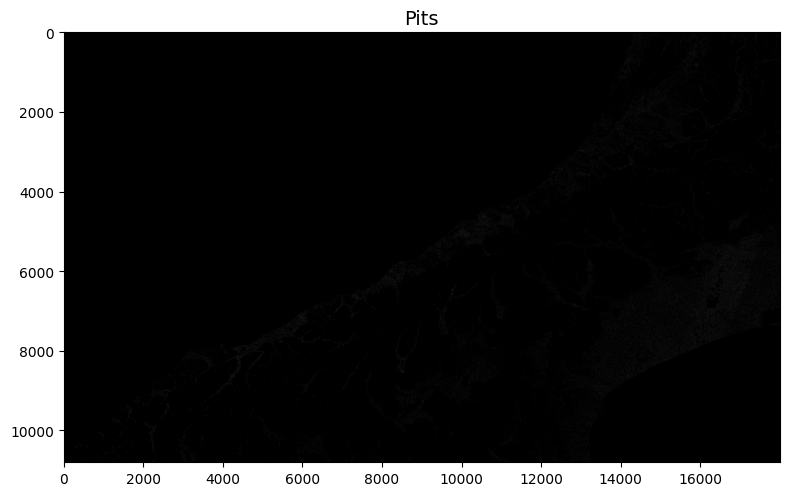

In [9]:
# Plot pits if more than zero
if npits > 0:
    # Plot pits
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_alpha(0)

    plt.imshow(pits, cmap="Greys_r", zorder=1)
    plt.title("Pits", size=14)
    plt.tight_layout()

_Visualization of the pits detected in the raw DEM._

As there are clearly many pits in the DEM (626,348), it is necessary to next fill in the pits using the `.fill_pits()` method. After doing this, we can check that the pits have been filled using an `assert` statement.

In [10]:
# Fill pits and check they have been filled
pit_filled_dem = grid.fill_pits(dem)
pits = grid.detect_pits(pit_filled_dem)
assert not pits.any()

So, now all pits have been filled, but other depressions may still exist in the DEM, which we will now detect (and fill if they exist). We can detect depressions using the `detect_depressions()` method.

In [11]:
# Detect depressions - Slow. May take 5 minutes or more.
depressions = grid.detect_depressions(pit_filled_dem)

In [ ]:
# ADD REMOVE CELL TAG

# Plot depressions
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(depressions, cmap="Greys_r", zorder=1)
plt.title("Depressions", size=14)
plt.tight_layout()

## Write output to file

Since the step above took a few minutes, let's save the current output to a file in case there is a need to start over from this point at some stage in the future.

In [ ]:
if checkpoint:
    # Write dataset to file
    grid.to_raster(
        pit_filled_dem,
        "checkpoint_data/pit_filled_dem.tif",
        blockxsize=16,
        blockysize=16,
    )
    # NOTE: Need to use "int" for dtype to avoid write error for boolean values
    grid.to_raster(
        depressions,
        "checkpoint_data/detected_depressions.tif",
        dtype=int,
        blockxsize=16,
        blockysize=16,
    )

In [ ]:
continue_from_here = False
if continue_from_here:
    grid, pit_filled_dem = continue_pysheds("checkpoint_data/pit_filled_dem.tif")
    _, depressions = continue_pysheds("checkpoint_data/detected_depressions.tif")

In [ ]:
# Fill depressions - Slow, takes 5-10 minutes...
flooded_dem = grid.fill_depressions(pit_filled_dem)
depressions = grid.detect_depressions(flooded_dem)
assert not depressions.any()

In [ ]:
if checkpoint:
    # Write dataset to file
    grid.to_raster(
        flooded_dem, "checkpoint_data/flooded_dem.tif", blockxsize=16, blockysize=16
    )

In [ ]:
continue_from_here = False
if continue_from_here:
    grid, flooded_dem = continue_pysheds("checkpoint_data/flooded_dem.tif")

In [ ]:
# Detect flats
flats = grid.detect_flats(flooded_dem)

In [ ]:
# ADD REMOVE CELL TAG

# Plot flats
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(flats, cmap="Greys_r", zorder=1)
plt.title("Flats", size=14)
plt.tight_layout()

In [ ]:
# Resolve flats
inflated_dem = grid.resolve_flats(flooded_dem)
flats = grid.detect_flats(inflated_dem)

In [ ]:
# ADD REMOVE CELL TAG

# Plot flats, if requested
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(flats, cmap="Greys_r", zorder=1)
plt.title("Flats", size=14)
plt.tight_layout()

In [ ]:
# Compute flow direction based on corrected DEM (D8)
fdir = grid.flowdir(inflated_dem)

# Compute flow accumulation based on computed flow direction
acc = grid.accumulation(fdir)

In [ ]:
# ADD REMOVE CELL TAG

# Plot flow accumulation, if requested
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
im = ax.imshow(
    acc,
    zorder=2,
    cmap="cubehelix",
    norm=colors.LogNorm(1, acc.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells")
plt.title("Flow Accumulation", size=14)
plt.tight_layout()

In [ ]:
if checkpoint:
    # Write flow accumulation and directions to file
    grid.to_raster(
        acc, "checkpoint_data/flow_accumulation.tif", blockxsize=16, blockysize=16
    )
    grid.to_raster(
        fdir, "checkpoint_data/flow_directions.tif", blockxsize=16, blockysize=16
    )

In [ ]:
continue_from_here = False
if continue_from_here:
    grid, acc = continue_pysheds("checkpoint_data/flow_accumulation.tif")
    _, fdir = continue_pysheds("checkpoint_data/flow_directions.tif")

In [ ]:
pour_points = [
    (168.723432, -44.060960),  # Big, glacial (Arawhata River)
    (168.838838, -44.023259),  # Small, glacial (Waiatoto River)
    (168.942363, -43.971371),  # Small, fluvial (Turnbull River)
    (168.987365, -43.952888),  # Medium, fluvial? (Okuru River)
    (169.144604, -43.935653),  # Big, mixed (Haast River)
    (169.351885, -43.785118),  # Medium, glacial (Moeraki River)
    (169.497063, -43.716472),  # Medium, mixed (Paringa River)
    (169.593608, -43.666203),  # Medium, mixed (Mahitahi River)
    (169.695061, -43.617701),  # Medium, mixed (Jacobs River)
    (169.808933, -43.576726),  # Medium-big, mixed (Karangarua River)
    (169.965037, -43.498121),  # Medium, mixed (Cook River)
    (170.008772, -43.478192),  # Medium, mixed (Fox River, glaciers present)
    (170.070511, -43.443732),  # Medium, fluvial? (Waikukupa River)
    (170.102720, -43.425248),  # Small, fluvial? (Omoeroa River)
    (170.182282, -43.394347),  # Medium, glacial (Waiho River)
    (170.274318, -43.343211),  # Small, fluvial (Waitangitaona River)
    (170.302801, -43.326779),  # Small, fluvial? (Darnley Creek)
    (170.403417, -43.285756),  # Big, mixed (Whataroa River)
    (170.525003, -43.217547),  # Medium, mixed (Poerua River)
    (170.624160, -43.158141),  # Big, mixed (Wanganui River)
    (170.729994, -43.107470),  # Medium, fluvial? (Waitaha River)
    (170.820316, -43.064461),  # Small, fluvial (Kakapotahi River?)
    (170.869467, -43.014418),  # Medium, fluvial (Mikonui River)
    (171.012521, -42.957962),  # Big, mixed (Hokitika River)
    (171.131477, -42.910875),  # Small, fluvial (Toaroha River)
    (171.150106, -42.903147),  # Small, fluvial (Kokatahi River)
    (171.165837, -42.884519),  # Medium, mixed (Styx River)
    (171.238172, -42.840905),  # Medium, mixed (Arahura River)
    (171.405012, -42.755411),  # Big, mixed (Taipo River)
    (171.467475, -42.733149),  # Very big, mixed (Taramakau River)
    (171.626527, -42.649998),  # Small, fluvial (Crooked River)
    (171.682798, -42.618596),  # Small, fluvial (Evans River)
    (171.733798, -42.612758),  # Medium, mixed fluvial (Haupiri River)
    (171.886492, -42.568796),  # Medium, fluvial (Waikiti River)
    (171.979749, -42.559885),  # Medium, mixed (Tutaekuri River)
    (171.995805, -42.546945),  # Medium, fluvial (Waiheke River)
    (172.012893, -42.471985),  # Medium, mixed (Robinson River)
    (172.136101, -42.411857),  # Small, mixed (Blue Grey River)
]

In [ ]:
river_names = [
    "Arawhata River",
    "Waiatoto River",
    "Turnbull River",
    "Okuru River",
    "Haast River",
    "Moeraki River",
    "Paringa River",
    "Mahitahi River",
    "Jacobs River",
    "Karangarua River",
    "Cook River",
    "Fox River",
    "Waikukupa River",
    "Omoeroa River",
    "Waiho River",
    "Waitangitaona River",
    "Darnley Creek",
    "Whataroa River",
    "Poerua River",
    "Wanganui River",
    "Waitaha River",
    "Kakapotahi River?",
    "Mikonui River",
    "Hokitika River",
    "Toaroha River",
    "Kokatahi River",
    "Styx River",
    "Arahura River",
    "Taipo River",
    "Taramakau River",
    "Crooked River",
    "Evans River",
    "Haupiri River",
    "Waikiti River",
    "Tutaekuri River",
    "Waiheke River",
    "Robinson River",
    "Blue Grey River",
]

In [ ]:
# Loop over river outlets and extract catchments

catchments = []
snap_points = []
catch_number = 0
print("Processing catchments", end="")
for pour_point in pour_points:
    catch_number += 1
    print(".", end="", flush=True)
    x_snap, y_snap = grid.snap_to_mask(acc > 1000, pour_point)

    # Save snapped pour points to a list for later use
    snap_points.append((x_snap, y_snap))

    # Delineate the catchment
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype="coordinate")

    # Append catchment to list
    catchments.append(catch)

print("done.")

In [ ]:
catchment_number = 15
cur_catch = catchments[catchment_number]

# Clip and set view extent
grid.clip_to(cur_catch)
catch_view = grid.view(cur_catch)
fdir_view = grid.view(fdir)
acc_view = grid.view(acc, nodata=np.nan)
dem_view = grid.view(dem, nodata=np.nan)

# Plot the catchment
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.patch.set_alpha(0)

plt.grid("on", zorder=0)

im = axes[0, 0].imshow(catch_view, extent=grid.extent, zorder=1, cmap="Greys_r")
im = axes[0, 1].imshow(dem_view, extent=grid.extent, zorder=1, cmap="viridis")
im = axes[1, 0].imshow(fdir_view, extent=grid.extent, zorder=1, cmap="viridis")
im = axes[1, 1].imshow(
    acc_view,
    extent=grid.extent,
    zorder=2,
    cmap="cubehelix",
    norm=colors.LogNorm(1, acc.max()),
    interpolation="bilinear",
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.suptitle("Delineated Catchment", size=14)
plt.tight_layout()

In [ ]:
# Compute distance to outlet
dist = grid.distance_to_outlet(
    x=snap_points[catchment_number][0],
    y=snap_points[catchment_number][1],
    fdir=fdir,
    xytype="coordinate",
)

In [ ]:
# ADD REMOVE CELL TAG

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2, cmap="cubehelix_r")
plt.colorbar(im, ax=ax, label="Distance to outlet (cells)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distance to outlet", size=14)

In [ ]:
# Extract river network
branches = grid.extract_river_network(fdir, acc > 100)

In [ ]:
# ADD REMOVE CELL TAG

fig, ax = plt.subplots(figsize=(8.5, 6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect("equal")

for branch in branches["features"]:
    line = np.asarray(branch["geometry"]["coordinates"])
    plt.plot(line[:, 0], line[:, 1])

plt.title("Channel network (>100 accumulation)", size=14);

In [ ]:
# CUT THIS?

strahler = grid.stream_order(fdir, acc > 100)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
cmap = colors.ListedColormap(
    ["white", "tab:blue", "tab:orange", "tab:green", "tab:red"]
)  # , "tab:purple"])
im = ax.imshow(strahler, extent=grid.extent, cmap=cmap)
plt.colorbar(im, ax=ax, label="Strahler stream order")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Strahler stream order", size=14)

In [ ]:
# Convert catchment data for xarray
catchment = dem_view
data = catchment.data

# Get latitude and longitude ranges
lat = np.unique(catchment.coords[:, 0])
# Get latitude points in correct order (reverse order of array values)
lat = np.flip(lat)
lon = np.unique(catchment.coords[:, 1])

catch_xr = xr.DataArray(catchment.base, coords={"y": lat, "x": lon}, dims=["y", "x"])

For convenience, the conversion to xarray has been saved as a function called `to_xarray()` in the `basin_functions.py` file.

In [ ]:
fig, ax = plt.subplots(1, 1)
catch_xr.plot(ax=ax, cmap="plasma")
ax.axis("equal")
plt.show()

In [ ]:
nbins = 20
counts, bins = np.histogram(catch_xr.values[~np.isnan(catch_xr.values)], bins=nbins)

In [ ]:
# ADD REMOVE CELL TAG?

# Plot elevation histogram
fig, ax = plt.subplots(1, 1)
ax.hist(catch_xr.values[~np.isnan(catch_xr.values)], bins=nbins)
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Number of occurences")
plt.tight_layout()

In [ ]:
# Calculate elevation histogram
catch_elev = catch_xr.values[~np.isnan(catch_xr.values)]
binsize = 50.0
minbin = catch_elev.min() - catch_elev.min() % +binsize
maxbin = catch_elev.max() - catch_elev.max() % -binsize
nbins = np.arange(minbin, maxbin + 1.0, binsize)
counts, bins = np.histogram(catch_elev, bins=nbins)

In [ ]:
# Plot elevation histogram
fig, ax = plt.subplots(1, 1)
ax.hist(catch_elev, bins=nbins)
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Number of occurences")
plt.tight_layout()

In [ ]:
# Normalize area distribution
norm_counts = counts.cumsum() / counts.cumsum().max()

# Convert to area above min elevation
norm_counts = 1 - norm_counts

# Normalize elevations
norm_bins = (bins - bins.min()) / (bins.max() - bins.min())

In [ ]:
# Calculate hypsometric integral
bin_width = norm_bins[1] - norm_bins[0]
hyps_integral = sum(norm_counts * bin_width)
print(f"Hypsometric integral: {abs(hyps_integral):.3f}")

In [ ]:
fig, ax = plt.subplots(1, 1)
# ax.plot(bins[:-1], counts, "k+")
ax.plot(norm_counts, bins[:-1], "r", label="Basin hypsometric curve")
ax.set_xlabel("Area fraction above elevation")
ax.set_ylabel("Elevation (m)")
ax.plot(
    [0.0, 1.0],
    [bins[:-1].max(), bins[:-1].min()],
    "--",
    color="gray",
    label="Linear reference",
)
ax.legend()
ax.set_xlim(0.0, 1.0)
ax.set_ylim(bins[:-1].min(), bins[:-1].max())
ax.text(
    0.05,
    (0.05 * bins[:-1].max()) + bins[:-1].min(),
    f"Hypsometric integral: {abs(hyps_integral):.3f}",
);

In [ ]:
# Loop over all catchments and calculate
# 1. Flow direction, flow accumulation, distance to outlet, channel network
# 2. Hypsometric integrals

# Create empty lists for storing outputs
catchment_numbers = []
catchment_lons = []
catchment_lats = []
catchment_areas = []
catchment_min_elevs = []
catchment_max_elevs = []
catchment_reliefs = []
catchment_his = []
catchment_boundaries = []

print("Processing catchments", end="")

for i in range(len(catchments)):
    catchment_number = i + 1
    cur_catch = catchments[i]
    # Clip and set view extent
    grid.clip_to(cur_catch)
    dem_view = grid.view(dem, nodata=np.nan)
    fdir_view = grid.view(fdir)
    acc_view = grid.view(acc, nodata=np.nan)
    # Compute distance to outlet
    dist = grid.distance_to_outlet(
        x=snap_points[i][0],
        y=snap_points[i][1],
        fdir=fdir,
        xytype="coordinate",
    )
    branches = grid.extract_river_network(fdir, acc > 100)

    # Save in xarray
    catchment = dem_view
    data = catchment.data
    lat = np.unique(catchment.coords[:, 0])
    lat = np.flip(lat)
    lon = np.unique(catchment.coords[:, 1])
    catch_xr = xr.DataArray(
        catchment.base, coords={"y": lat, "x": lon}, dims=["y", "x"]
    )

    # Save elevations without NaN values
    catch_elev = catch_xr.values[~np.isnan(catch_xr.values)]

    # Calculate elevation histogram
    counts, bins = calculate_hypsometry(catch_elev)

    # Calculate hypsometric integral
    hyps_integral = calculate_hypsometric_integral(counts, bins)

    # Extract vector boundary of catchment
    catch_xr.name = f"Catchment {catchment_number}"
    catch_gdf = vectorize(catch_xr.astype("float32"))
    catch_gdf = catch_gdf.dropna(subset=f"Catchment {catchment_number}")
    catch_gdf = catch_gdf.set_crs("epsg:4326")
    dissolved = catch_gdf.dissolve(method="unary")
    dissolved = dissolved.rename(columns={"geometry": "basin_boundary"})

    # Append catchment info to lists
    catchment_numbers.append(catchment_number)
    catchment_lons.append(pour_points[i][0])
    catchment_lats.append(pour_points[i][1])
    catchment_areas.append(round(calculate_area(catch_elev), 1))
    catchment_min_elevs.append(catch_elev.min())
    catchment_max_elevs.append(catch_elev.max())
    catchment_reliefs.append(calculate_relief(catch_elev))
    catchment_his.append(round(hyps_integral, 3))
    catchment_boundaries.append(dissolved["basin_boundary"].values[0])

    # Print some crap
    # print(f"Hypsometric  integral for catchment {i+1}: {abs(hyps_integral):.3f}")
    print(".", end="", flush=True)
print("done.")

In [ ]:
data = {
    "Catchment number": catchment_numbers,
    "River name": river_names,
    "Outlet longitude (deg.)": catchment_lons,
    "Outlet latitude (deg.)": catchment_lats,
    "Area (sq. km)": catchment_areas,
    "Min. elevation (m)": catchment_min_elevs,
    "Max. elevation (m)": catchment_max_elevs,
    "Relief (m)": catchment_reliefs,
    "Hypsometric integral": catchment_his,
    "Basin boundary": catchment_boundaries,
}

catchment_df = pd.DataFrame(data)
catchment_df.head()

In [ ]:
catchment_df["geometry"] = gpd.points_from_xy(
    x=catchment_df["Outlet longitude (deg.)"], y=catchment_df["Outlet latitude (deg.)"]
)

catchment_gdf = gpd.GeoDataFrame(catchment_df, crs="epsg:4326")

Read in data for the [Alpine Fault](https://data.gns.cri.nz/af/) [^alpinefault] ({cite}`Langridge2016`).

In [ ]:
# Read fault data from Geopackage
bucket_fault_file = "features/new_zealand/alpine_fault.gpkg"
bucket_fault_fp = bucket_home + bucket_fault_file

fault_df = gpd.read_file(bucket_fault_fp)

In [ ]:
basin_color_field = "Hypsometric integral"
m = fault_df.loc[fault_df["name"] == "Alpine Fault"].explore(
    column="name", cmap="gist_gray"
)
catchment_gdf["Points"] = catchment_gdf["geometry"]
catchment_gdf = catchment_gdf.set_geometry("Basin boundary")
m = catchment_gdf.explore(
    m=m,
    column=basin_color_field,
    cmap="plasma",
)
catchment_gdf = catchment_gdf.set_geometry("Points")
m = catchment_gdf.explore(m=m, color="black", marker_kwds={"radius": 2})
m

## Next steps

- Clean up the crap above
- Make things work such that you can loop over all catchments and produce an xarray dataset for each catchment containing:

    - Elevation model
    - Flow directions
    - Flow accumulation
    - Flow distance
    - Rasterized river network?

Perhaps some other metadata could also be exported from pysheds before going to xarray, but this needs to be looked over.

## Next next steps

- Once the above is done, it would be good to explore calculating the basin hypsometries, hypsometric integrals, and classifying basins according to their hypsometric integral values (fluvial, glacial, etc.).
- Finally, it would be cool to have an interactive map at the end where this info could be found by selecting basins

## Footnotes

[^affine]: <https://mattbartos.com/pysheds/raster.html>
[^alos]: <https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm>
[^alpinefault]: <https://data.gns.cri.nz/af/>
[^pysheds]: <https://mattbartos.com/pysheds/>
